In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import csv 

from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans

import time

In [2]:
def image_processing(img):
    #1) Image Scaling to 256x256
    img_resized = img.resize((256, 256))

    #2) Min-Max Linear Contrast
    # Convert the resized image to numpy array
    img_array = np.array(img_resized)
    # Find the minimum and maximum pixel values
    min_val = np.min(img_array)
    max_val = np.max(img_array)
    # Apply Min-Max Linear Contrast Stretch
    img_stretched = ((img_array - min_val) / (max_val - min_val)) * 255
    img_stretched = np.clip(img_stretched, 0, 255).astype(np.uint8)

    # 3) Color Transformation (RGB to HSI and use only the Hue channel)
    # Convert RGB image to HSV
    img_hsv = cv2.cvtColor(img_stretched, cv2.COLOR_RGB2HSV)
    # Extract the Hue channel and set all channels of img_stretched to it
    img_stretched[:,:,0] = img_hsv[:,:,0]
    img_stretched[:,:,1] = img_hsv[:,:,0]
    img_stretched[:,:,2] = img_hsv[:,:,0]
    return img_stretched

In [3]:
def image_segmentation(img_hue, num_clusters = 3):
    #4) K-means clustering
    # Flatten the image array to a 2D array (pixels as rows, RGB as columns)
    img_flat = img_hue.reshape((-1, 3))
    kmeans = KMeans(n_clusters=num_clusters, random_state=22, n_init=10)
    kmeans.fit(img_flat)
    return kmeans.labels_

In [4]:
def feature_extraction(label, cluster_labels, num_clusters, angles, properties):
    grayscale_image = np.zeros_like(cluster_labels, dtype=np.uint8)
    # Map cluster labels to grayscale values using a linear or custom mapping
    grayscale_mapping = np.linspace(0, 255, num_clusters + 1)[1:]  # Linear mapping
    # grayscale_mapping = custom_mapping  # For custom mapping
    grayscale_image[cluster_labels == 0] = grayscale_mapping[0]
    for i in range(1, num_clusters):
        grayscale_image[cluster_labels == i] = grayscale_mapping[i]

    #Apply GLCM
    distances = [1]    
    glcm = graycomatrix(grayscale_image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Extract GLCM properties
    #features = np.hstack([graycoprops(glcm, prop).ravel() for prop in properties])
    features = []
    glcm_props = [propery for name in properties for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
        features.append(item)
    features.append(label) 
    return features

In [5]:
def save_features(csv_file_path, angles, properties, features):
    columns = []
    for name in properties:
        for ang in angles:
            columns.append(name + "_" + ang)
    columns.append("label")
    #print(columns)
    
    # Check file existence and create if needed
    if not os.path.exists(csv_file_path):
        with open(csv_file_path, 'w', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            csv_writer.writerow(columns)

    # Write data for each image (append mode)
    with open(csv_file_path, 'a', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(features)

    print(columns)
    print(features)

In [6]:
def processImages(data_dir, csv_file_path, printImages = True, num_clusters = 3, angles = ['0', '45', '90','135'], properties = ['contrast', 'correlation', 'energy', 'homogeneity',  'ASM', 'dissimilarity']):
    print("====================================================")
    print("==================Image Processing==================")
    print("====================================================")
    start_time = time.time()

    # Delete file if it exist
    if os.path.exists(csv_file_path):
        os.remove(csv_file_path)
        print(f"CSV file '{csv_file_path}' deleted successfully.")
    else:
        print(f"CSV file '{csv_file_path}' not found.")

    count = 0
    for class_dir in os.listdir(data_dir):
        class_label = class_dir  # class_label is the folder name
        for img_file in os.listdir(os.path.join(data_dir, class_dir)):
            count += 1 
            img_path = os.path.join(data_dir, class_dir, img_file)
            img = Image.open(img_path)

            img_hue = image_processing(img)

            cluster_labels = image_segmentation(img_hue, num_clusters).reshape(img_hue.shape[:2])

            features = feature_extraction(class_label, cluster_labels, num_clusters, angles, properties)
            print(count, class_label, img_file, "-------------------------------------------------------------")
            save_features(csv_file_path, angles, properties, features)
            if printImages:
                img_array = np.array(img_hue)
                # Reshape the labels to the shape of the original image
                cluster_labels = cluster_labels.reshape(img_array.shape[:2])

                fig, axes = plt.subplots(1, 2, figsize=(5, 5))
                axes[0].axis('off')
                axes[0].imshow(img)
                axes[1].axis('off')
                axes[1].imshow(cluster_labels, cmap='viridis')
                plt.show()

    print("Done!!")
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.4f} seconds")

==================Image Processing==================
CSV file 'D:/pythonProject/Image-research/vision/color-train-50.csv' deleted successfully.
1 Pepper,_bell___Bacterial_spot 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[353.28124999999994, 468.33333333333337, 350.29296874999994, 353.28124999999994, 0.9374104831668759, 0.917219780777666, 0.9379292488421533, 0.9374104831668759, 0.6474171436610645, 0.6443602099563578, 0.6477084611757343, 0.6474171436610645, 0.9803785411055854, 0.9745811629693446, 0.9806542430106117, 0.9803785411055854

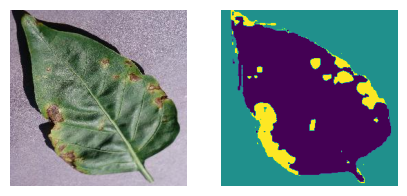

2 Pepper,_bell___Bacterial_spot 01dfb88b-cd5a-420c-b163-51f5fe07b74d___JR_B.Spot 9091.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[623.22265625, 891.5555555555555, 549.9544270833334, 623.22265625, 0.92914201043207, 0.8987417758673785, 0.9374879848240347, 0.92914201043207, 0.603597556209686, 0.5969711969667313, 0.606224294421936, 0.603597556209686, 0.9607115333418672, 0.943458031029609, 0.9674968622351001, 0.9607115333418672, 0.3643300098623051, 0.3563746100078919, 0.36750789514737425, 0.3643300098623051, 4.670572916666667, 6.700653594771241, 3.9986979166666665, 4.670572916666667, 'Pepp

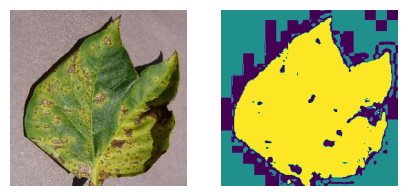

3 Pepper,_bell___Bacterial_spot 0a4c007d-41ab-4659-99cb-8a4ae4d07a55___NREC_B.Spot 1954.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[154.5052083333333, 243.66666666666669, 191.58203125000003, 154.5052083333333, 0.9629498363175106, 0.9416335770169342, 0.9540474707047176, 0.9629498363175106, 0.6808519442800275, 0.672547565473786, 0.676999490715175, 0.6808519442800275, 0.9786641034359387, 0.9663253051664877, 0.9735330734170257, 0.9786641034359387, 0.4635593700298936, 0.4523202278247165, 0.4583283104286063, 0.4635593700298936, 1.815104166666666, 2.864052287581699, 2.251302083333334, 1.8151

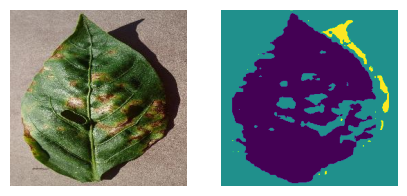

4 Pepper,_bell___Bacterial_spot 0abffc81-6be8-4b17-a83c-4d2830e30382___JR_B.Spot 9076.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[444.92187500000006, 718.0, 443.8151041666667, 444.92187500000006, 0.9194764340223053, 0.8694380598844802, 0.9197645425649382, 0.9194764340223053, 0.6617382988076166, 0.6571657463736827, 0.6617078180510337, 0.6617382988076166, 0.975737361095859, 0.9612489406054605, 0.976120265834368, 0.975737361095859, 0.4378975761087985, 0.43186681820687955, 0.4378572364698599, 0.4378975761087985, 3.119791666666667, 5.011764705882353, 3.0937500000000004, 3.119791666666667, 

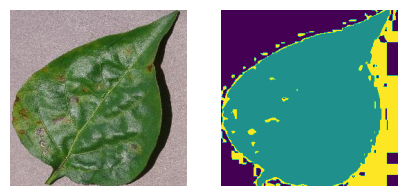

5 Pepper,_bell___Bacterial_spot 0b27c03f-b3bc-4d96-9b76-6fbd779404b9___NREC_B.Spot 1799.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[122.51953125000001, 181.8888888888889, 139.453125, 122.51953125000001, 0.9727756583101073, 0.9595823794451652, 0.9690238551986223, 0.9727756583101073, 0.6804426301370903, 0.6762570965667876, 0.6793306163282021, 0.6804426301370903, 0.9832743658396257, 0.9752437043050755, 0.9810228360545237, 0.9832743658396257, 0.46300217290788104, 0.4573236606569414, 0.46149008628085497, 0.46300217290788104, 1.4283854166666667, 2.1163398692810462, 1.6223958333333333, 1.428

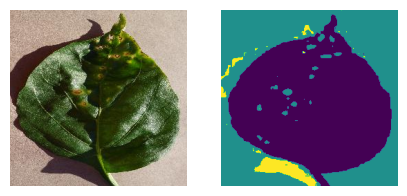

6 Pepper,_bell___Bacterial_spot 0b47ce18-7cfe-45e8-b21e-b83cb6282455___JR_B.Spot 3162.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[539.8828125, 765.4444444444445, 608.1705729166666, 539.8828125, 0.9157432615356704, 0.8806528918560986, 0.9050327151011235, 0.9157432615356704, 0.6730626555394755, 0.6688789291840269, 0.6716559675614412, 0.6730626555394755, 0.9749098435982695, 0.9651542276368824, 0.9726274359544742, 0.9749098435982695, 0.4530133382818507, 0.4473990219063705, 0.4511217387608957, 0.4530133382818507, 3.5390624999999996, 4.976470588235294, 3.936197916666665, 3.5390624999999996,

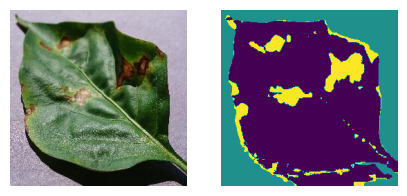

7 Pepper,_bell___Bacterial_spot 0bd0f439-013b-40ed-a6d1-4e67e971d437___JR_B.Spot 3272.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[437.28515625000006, 688.2222222222222, 447.68880208333337, 437.28515625000006, 0.9551070947345381, 0.9295951658912719, 0.9540903908495151, 0.9551070947345381, 0.5666116153668578, 0.5593644550855097, 0.5659283069700584, 0.5666116153668578, 0.978678065353886, 0.9659695275379224, 0.9775599491757316, 0.978678065353886, 0.32104872266864004, 0.3128885936131092, 0.32027484862999656, 0.32104872266864004, 2.9231770833333335, 4.627450980392156, 3.02734375, 2.92317708

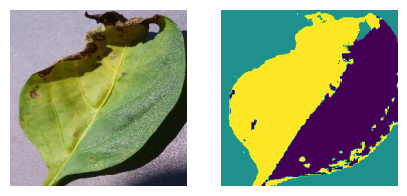

8 Pepper,_bell___Bacterial_spot 0c1eb1fd-9e3a-4396-81bc-7d1d3eccc5ed___JR_B.Spot 3369.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[656.6471354166666, 947.6666666666667, 685.5338541666666, 656.6471354166666, 0.9303406947170357, 0.8995807356362758, 0.9274647345788951, 0.9303406947170357, 0.6371790509083074, 0.6298776735587657, 0.6357103534199671, 0.6371790509083074, 0.9693649006108569, 0.9544670071394423, 0.9671592615222395, 0.9693649006108569, 0.40599714291641137, 0.39674588364780294, 0.40412765344533946, 0.40599714291641137, 4.311197916666667, 6.29673202614379, 4.549479166666667, 4.311

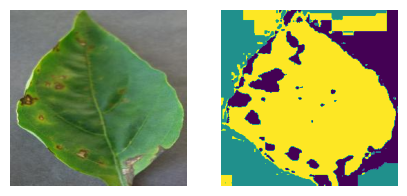

9 Pepper,_bell___Bacterial_spot 0c2392f6-3e69-4baf-b9f3-197623f6631a___JR_B.Spot 3176.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[492.40234375000006, 748.0, 557.7018229166666, 492.40234375000006, 0.9290608389943125, 0.8925458280898971, 0.9197460387314389, 0.9290608389943125, 0.6190686554365256, 0.6142381977996588, 0.6172791336830475, 0.6190686554365256, 0.9773453113842613, 0.9669686839125886, 0.973868271800258, 0.9773453113842613, 0.38324600014398763, 0.3772885636361728, 0.3810335288804937, 0.38324600014398763, 3.2148437500000004, 4.8052287581699344, 3.6679687499999996, 3.214843750000

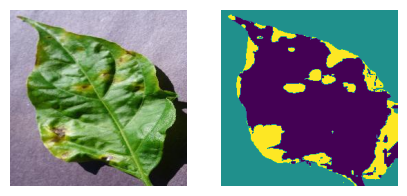

10 Pepper,_bell___Bacterial_spot 0c4e75b2-e4aa-437e-815c-636271d66bec___JR_B.Spot 3244.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[315.5403645833333, 533.8888888888889, 425.8854166666668, 315.5403645833333, 0.9454896136873875, 0.9079409390427154, 0.926456462811962, 0.9454896136873875, 0.6529239103514941, 0.6482867652431269, 0.650844525641475, 0.6529239103514941, 0.983074333873117, 0.9724743315550366, 0.9786015400524696, 0.983074333873117, 0.42630963270868594, 0.42027572998939716, 0.42359859655747656, 0.42630963270868594, 2.196614583333333, 3.65359477124183, 2.8828125000000004, 2.19661

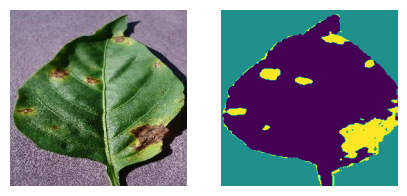

11 Pepper,_bell___Bacterial_spot 0c99cb45-b4e0-4ade-bba5-fab3b678f0bb___JR_B.Spot 8912.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[496.7187500000001, 736.7777777777777, 466.0611979166667, 496.7187500000001, 0.9104300954378435, 0.8670296336466266, 0.9159445841995882, 0.9104300954378435, 0.6484332210477535, 0.6435657369955884, 0.6485784742213745, 0.6484332210477535, 0.975553321341762, 0.9626634463896753, 0.9760282634461521, 0.975553321341762, 0.42046564215836474, 0.41417685783467484, 0.4206540372233261, 0.42046564215836474, 3.333333333333334, 5.005228758169935, 3.1861979166666674, 3.333

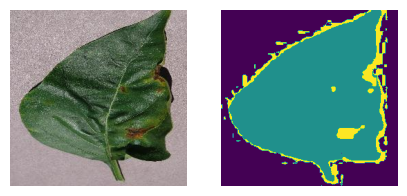

12 Pepper,_bell___Bacterial_spot 0ce74db6-be9b-4c43-a104-6a3f9bcd2de2___NREC_B.Spot 1827.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[498.6002604166667, 765.4444444444443, 618.6848958333333, 498.6002604166667, 0.9634750968880139, 0.9439501655502505, 0.9546655807379185, 0.9634750968880139, 0.6639618671028842, 0.6560946293837332, 0.6599119222655117, 0.6639618671028842, 0.9797039422496389, 0.9667225837384656, 0.9725048577873991, 0.9797039422496389, 0.4408453609667481, 0.43046016270617826, 0.43548374514816274, 0.4408453609667481, 3.1054687500000004, 4.887581699346406, 3.984375, 3.105468750

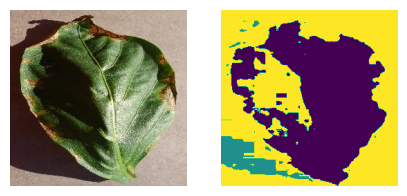

13 Pepper,_bell___Bacterial_spot 0d2635e7-df23-4ceb-b3ba-3af50bb58357___NREC_B.Spot 1874.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[119.30989583333336, 176.11111111111111, 128.49609375, 119.30989583333336, 0.9674671181650915, 0.9518911943149828, 0.9649357666591093, 0.9674671181650915, 0.7018448387797671, 0.6977007456337445, 0.7010424226561223, 0.7018448387797671, 0.9840861280189895, 0.9766890797511973, 0.9829067537602276, 0.9840861280189895, 0.4925861777217973, 0.486786330457883, 0.49146047836356516, 0.4925861777217973, 1.3697916666666672, 2.011764705882353, 1.4726562500000002, 1.369

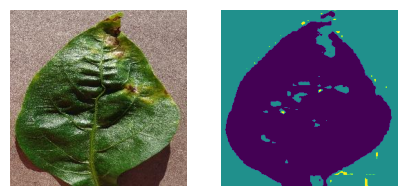

14 Pepper,_bell___Bacterial_spot 0d9b55df-a8c0-4784-b1e4-957c8d679513___NREC_B.Spot 1825.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[457.76041666666663, 630.3333333333333, 483.76953125, 457.76041666666663, 0.9664005834035122, 0.9537725790272982, 0.9644809226443866, 0.9664005834035122, 0.6767355863964054, 0.67146745240103, 0.6755776029317698, 0.6767355863964054, 0.9811285237191547, 0.9729197749079233, 0.9795049055566893, 0.9811285237191547, 0.4579710538952867, 0.4508685396339295, 0.45640509758303605, 0.4579710538952867, 2.864583333333333, 4.006535947712418, 3.05859375, 2.86458333333333

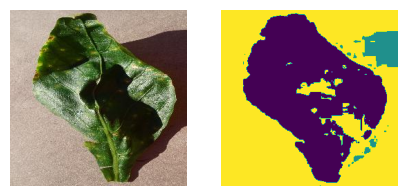

15 Pepper,_bell___Bacterial_spot 0efa6329-22f4-4bf0-a67a-17b0d5e4d2f2___NREC_B.Spot 9145.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[394.67447916666663, 556.4444444444445, 383.1640625, 394.67447916666663, 0.9306637101893462, 0.9024360181975095, 0.9326491834303379, 0.9306637101893462, 0.64406556169246, 0.6394916745530167, 0.645480918560402, 0.64406556169246, 0.9726744061888923, 0.9627104380159592, 0.9763809278734075, 0.9726744061888923, 0.414820447758224, 0.4089496018226214, 0.4166456162255804, 0.414820447758224, 3.096354166666667, 4.295424836601307, 2.8411458333333335, 3.0963541666666

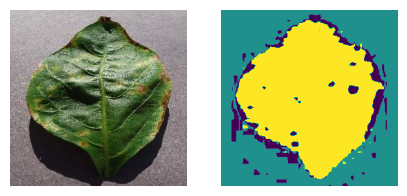

16 Pepper,_bell___Bacterial_spot 0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[489.74609374999994, 691.4444444444443, 496.0546874999999, 489.74609374999994, 0.9230109976537999, 0.8914463790404459, 0.922036308501219, 0.9230109976537999, 0.6451783434277095, 0.6409975938026278, 0.6454825408709186, 0.6451783434277095, 0.9706369259345312, 0.9598037199838267, 0.9720612816391183, 0.9706369259345312, 0.4162550948281235, 0.4108779152607586, 0.41664771056917704, 0.4162550948281235, 3.5846354166666665, 4.98954248366013, 3.5286458333333326, 3.

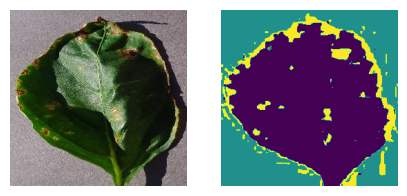

17 Pepper,_bell___Bacterial_spot 1ade72cf-f7e0-4282-92d9-614bf05289a0___NREC_B.Spot 1975.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[105.80729166666667, 158.77777777777783, 120.74869791666666, 105.80729166666667, 0.9722079268751858, 0.9583252815033454, 0.9682803789025544, 0.9722079268751858, 0.6944803186545001, 0.6899453662458328, 0.693349792140256, 0.6944803186545001, 0.9855412105423527, 0.9785342875752839, 0.9837032216905861, 0.9855412105423527, 0.48230291299845607, 0.4760246084040964, 0.4807339342609363, 0.48230291299845607, 1.234375, 1.83921568627451, 1.3971354166666665, 1.234375,

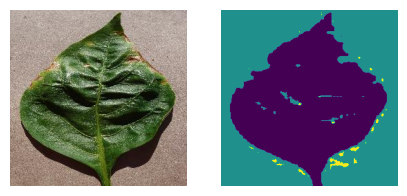

18 Pepper,_bell___Bacterial_spot 1aeb4d06-0069-4fea-be9f-3200ac2e9373___NREC_B.Spot 1909.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[118.203125, 206.7777777777778, 169.00390625, 118.203125, 0.9693538327272888, 0.9464457306615027, 0.9561576545287443, 0.9693538327272888, 0.698071424804712, 0.6911731416187263, 0.6944883789713695, 0.698071424804712, 0.98410144929619, 0.9727680426533953, 0.9778982351328473, 0.98410144929619, 0.4873037141288806, 0.4777203116950999, 0.48231410852628054, 0.4873037141288806, 1.3645833333333335, 2.3542483660130724, 1.9153645833333333, 1.3645833333333335, 'Peppe

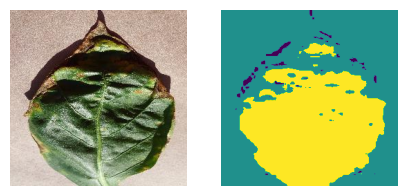

19 Pepper,_bell___Bacterial_spot 1c0c1501-f362-49d0-9e99-e72006441c8c___JR_B.Spot 8869.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[519.4075520833333, 695.2222222222222, 550.1757812500001, 519.4075520833333, 0.9113351499750866, 0.8814935437999226, 0.9061569596210599, 0.9113351499750866, 0.6367917150406417, 0.6312159521966927, 0.6357572644453269, 0.6367917150406417, 0.9694268216772054, 0.957112894857338, 0.9672364895567441, 0.9694268216772054, 0.40550368834440176, 0.3984335783075774, 0.40418729929500535, 0.40550368834440176, 3.76953125, 5.15686274509804, 4.014322916666668, 3.76953125, '

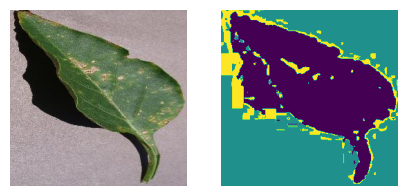

20 Pepper,_bell___Bacterial_spot 1cb295da-e568-4168-a29c-48ab980f3772___NREC_B.Spot 9250.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[479.89583333333337, 707.2222222222223, 468.0533854166667, 479.89583333333337, 0.9427450806079816, 0.9159175415851531, 0.944244905987795, 0.9427450806079816, 0.5826313033752699, 0.5746377871678058, 0.5817002877609279, 0.5826313033752699, 0.9721379389017258, 0.9560518906221028, 0.970606397852488, 0.9721379389017258, 0.33945923567276576, 0.3302085864411124, 0.3383752247811463, 0.33945923567276576, 3.4609375, 5.264052287581699, 3.5013020833333335, 3.4609375,

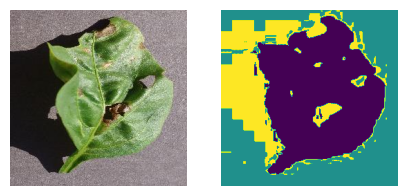

21 Pepper,_bell___Bacterial_spot 1cce64aa-6f9f-4ce1-b319-dbc4a012b240___JR_B.Spot 8998.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[234.41406250000006, 395.1111111111111, 235.078125, 234.41406250000006, 0.9805030570592174, 0.9671138734098361, 0.9804298541374626, 0.9805030570592174, 0.5970502043810945, 0.5870963512076139, 0.5966392036634429, 0.5970502043810945, 0.9679272205357621, 0.9461512152343778, 0.9676515297599928, 0.9679272205357621, 0.3564689465515066, 0.344682125601294, 0.3559783393481474, 0.3564689465515066, 2.7369791666666674, 4.601307189542483, 2.755208333333334, 2.7369791666

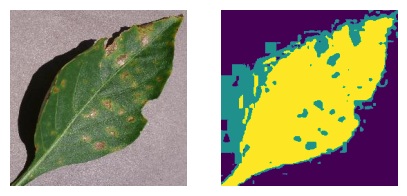

22 Pepper,_bell___Bacterial_spot 1d26f9c5-2f4e-4b1e-a7d6-a4e9584a3ab7___JR_B.Spot 8918.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[699.0364583333333, 1246.3333333333328, 803.18359375, 699.0364583333333, 0.9050920530167457, 0.8304297747838679, 0.8909735970541588, 0.9050920530167457, 0.5935326274792941, 0.5809995260291315, 0.5900499009898105, 0.5935326274792941, 0.9652446996722406, 0.9367523786843274, 0.9579997435922427, 0.9652446996722406, 0.3522809798824746, 0.3375604492460755, 0.34815888565808517, 0.3522809798824746, 4.7109375, 8.4718954248366, 5.529947916666667, 4.7109375, 'Pepper,_

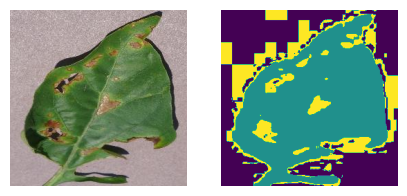

23 Pepper,_bell___Bacterial_spot 1d2949cc-b0fa-4a29-8540-2983230c34e9___JR_B.Spot 9017.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[680.4427083333334, 1015.5555555555555, 786.1393229166669, 680.4427083333334, 0.9241116494360604, 0.8868589258129611, 0.9121854756396395, 0.9241116494360604, 0.5859623069407506, 0.57803098231319, 0.5842962714960728, 0.5859623069407506, 0.9641420383223711, 0.9467325338347877, 0.961093652672808, 0.9641420383223711, 0.34335182515532636, 0.33411981651395134, 0.34140213288421234, 0.34335182515532636, 4.700520833333333, 7.001307189542484, 5.287760416666669, 4.700

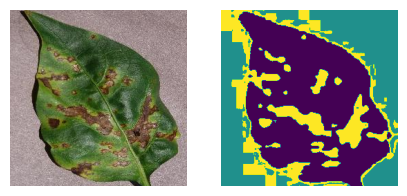

24 Pepper,_bell___Bacterial_spot 1d46d97c-17ae-41e2-9ac3-6a984804760e___JR_B.Spot 8825.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[427.43489583333337, 632.6666666666664, 455.7682291666667, 427.43489583333337, 0.9510589698575603, 0.9275726203355426, 0.9477329324440275, 0.9510589698575603, 0.6006600084594319, 0.5948745766272878, 0.600253179221487, 0.6006600084594319, 0.9712192314516848, 0.9564058965477646, 0.9703307690825795, 0.9712192314516848, 0.36079244576248476, 0.353875761917495, 0.36030387916550266, 0.36079244576248476, 3.307291666666667, 4.951633986928103, 3.46875, 3.307291666666

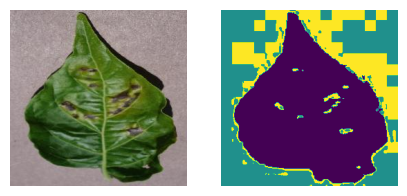

25 Pepper,_bell___Bacterial_spot 1f3b1b11-4934-4c0b-b054-8f8a977b488c___JR_B.Spot 3373.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[561.5755208333334, 814.6666666666664, 583.2682291666666, 561.5755208333334, 0.9236987976023655, 0.8896361632828025, 0.920890141176307, 0.9236987976023655, 0.6031227472564619, 0.5965878955703735, 0.6020899706930817, 0.6031227472564619, 0.9742971006230228, 0.9618942714170123, 0.9731329824558133, 0.9742971006230228, 0.36375704825818195, 0.3559171171410869, 0.362512332809196, 0.36375704825818195, 3.6588541666666674, 5.354248366013071, 3.8098958333333326, 3.658

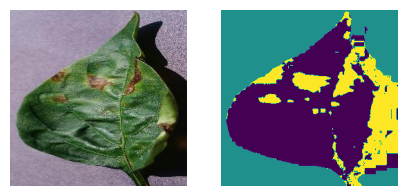

26 Pepper,_bell___Bacterial_spot 2f26c2e1-a13d-41c9-9adf-51fb0ad99785___NREC_B.Spot 1849.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[337.12239583333326, 491.77777777777794, 320.7421875, 337.12239583333326, 0.9229718215968529, 0.8876828196528318, 0.9266627211578167, 0.9229718215968529, 0.6852430437220628, 0.6787491303636674, 0.6850946374205445, 0.6852430437220628, 0.9794443438495941, 0.9690303001919027, 0.9794137903292491, 0.9794443438495941, 0.4695580289694768, 0.4607003819694347, 0.46935466222238736, 0.4695580289694768, 2.486979166666666, 3.6836601307189554, 2.4244791666666665, 2.486

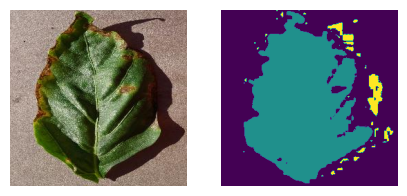

27 Pepper,_bell___Bacterial_spot 3a03526d-0bf4-4898-9f0f-8a9c31afd3eb___JR_B.Spot 3380.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[161.92057291666669, 206.44444444444446, 181.17838541666666, 161.92057291666669, 0.986088533014058, 0.9822679467847534, 0.9844306290828319, 0.986088533014058, 0.6029791276038245, 0.6001210163753057, 0.60172711215397, 0.6029791276038245, 0.9779135850281377, 0.9729064286114282, 0.9759836796424235, 0.9779135850281377, 0.36358382832586933, 0.3601452342953299, 0.3620755175011564, 0.36358382832586933, 1.8867187500000002, 2.345098039215686, 2.0716145833333335, 1.8

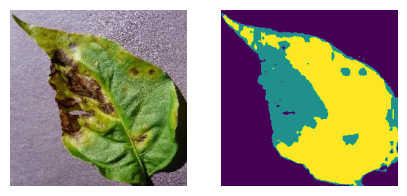

28 Pepper,_bell___Bacterial_spot 4d035250-f831-438b-a583-d192cbb26a55___JR_B.Spot 3163.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[272.70833333333337, 431.3333333333333, 297.0572916666667, 272.70833333333337, 0.9496226770774647, 0.9204312111494538, 0.945124701816524, 0.9496226770774647, 0.6733539484159814, 0.6672417940425193, 0.6723389666228444, 0.6733539484159814, 0.9794906002216673, 0.9667395596317192, 0.9768101875574094, 0.9794906002216673, 0.4534055398473922, 0.4452116117170797, 0.45203968603947425, 0.4534055398473922, 2.2317708333333335, 3.576470588235294, 2.479166666666667, 2.23

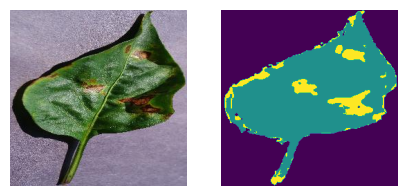

29 Pepper,_bell___Bacterial_spot 4f539b76-13f8-43ab-a630-0cc6b1461bc9___JR_B.Spot 3381.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[329.15364583333337, 433.22222222222223, 296.06119791666663, 329.15364583333337, 0.9620975420820629, 0.9500988452698451, 0.9659041290994215, 0.9620975420820629, 0.5855852963953715, 0.5813499518497722, 0.5867529470462844, 0.5855852963953715, 0.9788930068150843, 0.9706296887605242, 0.9804860269401763, 0.9788930068150843, 0.3429101393544551, 0.33796776651573246, 0.34427902086749984, 0.3429101393544551, 2.486979166666667, 3.3633986928104576, 2.2669270833333335,

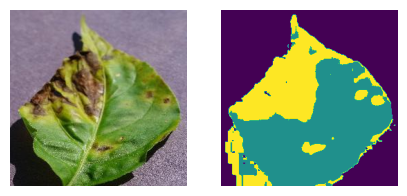

30 Pepper,_bell___Bacterial_spot 5d3a800b-58ed-41f4-ad9a-ad92217a5316___JR_B.Spot 9027.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[597.4348958333333, 850.9999999999999, 586.2565104166666, 597.4348958333333, 0.9234377441012146, 0.8909064126545432, 0.9249151587291301, 0.9234377441012146, 0.6222496108294292, 0.6162847567050928, 0.6223505471951744, 0.6222496108294292, 0.964785706853127, 0.9482401737310798, 0.965643455122607, 0.964785706853127, 0.3871945781773761, 0.3798069013470553, 0.387320203594133, 0.3871945781773761, 4.338541666666666, 6.2705882352941185, 4.24609375, 4.338541666666666

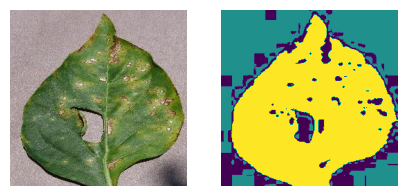

31 Pepper,_bell___healthy 01fbd010-0cc1-4c48-98bc-49e328bf9bbc___JR_HL 8584.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[330.9244791666668, 474.8888888888889, 336.2369791666667, 330.9244791666668, 0.9202763907975783, 0.8854964336180354, 0.9190926552222245, 0.9202763907975783, 0.6892192683120043, 0.6858391990610421, 0.6893062081510144, 0.6892192683120043, 0.9815426624525828, 0.9732587921206152, 0.9820940122062437, 0.9815426624525828, 0.4750231998125346, 0.47037540696869173, 0.47514304859552964, 0.4750231998125346, 2.3437500000000004, 3.3777777777777778, 2.3333333333333335, 2.34375000000

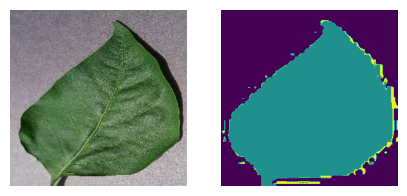

32 Pepper,_bell___healthy 0a3f2927-4410-46a3-bfda-5f4769a5aaf8___JR_HL 8275.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[305.6901041666667, 387.6666666666667, 235.29947916666674, 305.6901041666667, 0.9696667927379647, 0.9615405454160258, 0.9766848218793334, 0.9696667927379647, 0.5883185920329475, 0.5854687116438912, 0.5906345535041756, 0.5883185920329475, 0.9772696255468045, 0.970245505892829, 0.9813593286113615, 0.9772696255468045, 0.34611876573162964, 0.34277361231395787, 0.3488491757930769, 0.34611876573162964, 2.4869791666666665, 3.2065359477124185, 1.979166666666667, 2.48697916666

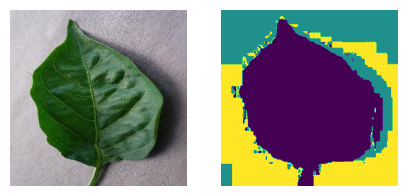

33 Pepper,_bell___healthy 0b76f650-27cf-4b62-b3ad-c97d81e0db0c___JR_HL 8554.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[306.79687499999994, 416.1111111111111, 273.92578125, 306.79687499999994, 0.9401693435541816, 0.9189188815422978, 0.946666107438955, 0.9401693435541816, 0.67168318827662, 0.6687664693631583, 0.6722118452094699, 0.67168318827662, 0.9789084298454922, 0.9700916092877271, 0.9807924524841911, 0.9789084298454922, 0.45115830541344537, 0.4472485905444642, 0.4518687648399203, 0.45115830541344537, 2.3984374999999996, 3.3267973856209148, 2.162760416666667, 2.3984374999999996, 'P

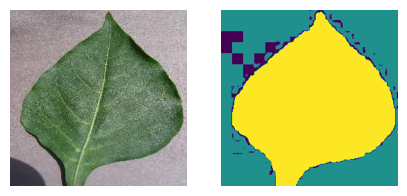

34 Pepper,_bell___healthy 0ba474dd-0cfd-4fd2-a58c-8e3d18dbe7c3___JR_HL 8395.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[502.2526041666668, 728.3333333333333, 477.5716145833333, 502.2526041666668, 0.8993867221649178, 0.8533652026820208, 0.9043117448964759, 0.8993867221649178, 0.6774009662097243, 0.6738237723150801, 0.6777461296962201, 0.6774009662097243, 0.9752010273597769, 0.9630478878302267, 0.9761813681053768, 0.9752010273597769, 0.45887206902186817, 0.45403847613692483, 0.4593398163182055, 0.45887206902186817, 3.3750000000000004, 4.95032679738562, 3.2226562500000004, 3.375000000000

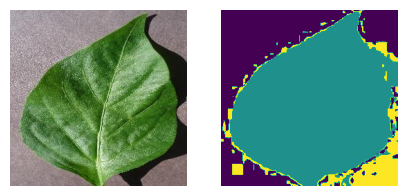

35 Pepper,_bell___healthy 0e043e9a-7652-4e7a-aef1-0caa0c085f55___JR_HL 8479.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[159.48567708333331, 264.6666666666667, 146.5364583333333, 159.48567708333331, 0.9744645311294916, 0.9573908823059842, 0.9765673556146162, 0.9744645311294916, 0.7141309821278524, 0.7109857094337391, 0.7149656682783808, 0.7141309821278524, 0.9826615497292612, 0.9737057039119446, 0.9848211645703093, 0.9826615497292612, 0.5099830596348911, 0.5055006790189973, 0.5111759068167516, 0.5099830596348911, 1.6080729166666667, 2.5281045751633986, 1.434895833333333, 1.608072916666

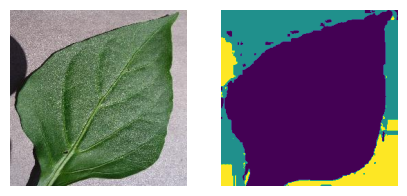

36 Pepper,_bell___healthy 0e05c3e0-7766-4049-b7a8-563b5c028c33___JR_HL 8828.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[258.3203125, 428.1111111111111, 276.4713541666667, 258.3203125, 0.9765832858976009, 0.9612123334836111, 0.9749247928494148, 0.9765832858976009, 0.5874056308020841, 0.5831282405274054, 0.5875340285593369, 0.5874056308020841, 0.9849278411489237, 0.9768723855604076, 0.9857241850675611, 0.9849278411489237, 0.34504537509799427, 0.3400385449005876, 0.3451962347151637, 0.34504537509799427, 1.8671875000000002, 2.9895424836601308, 1.893229166666667, 1.8671875000000002, 'Peppe

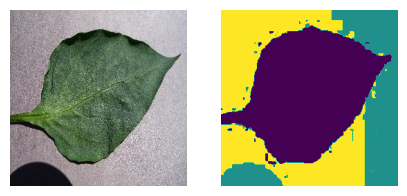

37 Pepper,_bell___healthy 0e1942a4-91d7-460a-8189-1a4e693cfc84___JR_HL 8896.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[419.5768229166667, 555.0000000000001, 370.87890625000006, 419.5768229166667, 0.9481378420217597, 0.9313154422740962, 0.954157957474976, 0.9481378420217597, 0.6303694233558234, 0.6266934511643588, 0.6316725114394325, 0.6303694233558234, 0.9695957754583936, 0.9565446528076662, 0.9721997248270958, 0.9695957754583936, 0.39736560990195324, 0.3927446817322946, 0.3990101617081999, 0.39736560990195324, 3.368489583333333, 4.639215686274511, 3.0299479166666674, 3.3684895833333

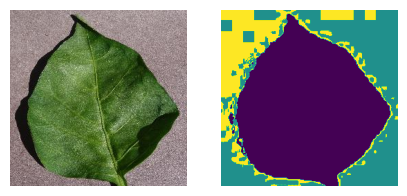

38 Pepper,_bell___healthy 0e526c7b-72ee-4547-916b-5cba013097b6___JR_HL 7735.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[340.8854166666667, 468.66666666666674, 323.1770833333333, 340.8854166666667, 0.940465488023815, 0.9177425688085289, 0.9436138143435792, 0.940465488023815, 0.6571759041389095, 0.6548449277344136, 0.6574869783524773, 0.6571759041389095, 0.981818302351748, 0.974119880166868, 0.9829364535075679, 0.981818302351748, 0.43188016898079307, 0.4288218793794894, 0.43228912670307085, 0.43188016898079307, 2.3671875, 3.304575163398694, 2.234375, 2.3671875, 'Pepper,_bell___healthy']

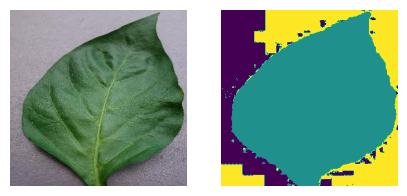

39 Pepper,_bell___healthy 0e5d9ac1-4de8-491e-ab95-809850866805___JR_HL 8534.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[328.4895833333333, 410.0000000000001, 312.33072916666663, 328.4895833333333, 0.9312101215631946, 0.914096931780974, 0.9345576592120182, 0.9312101215631946, 0.6798573105616427, 0.6780188201887442, 0.6801448318399165, 0.6798573105616427, 0.9799498124461342, 0.9736588798791788, 0.9802562093720592, 0.9799498124461342, 0.4622059627241099, 0.4597095205301366, 0.4625969922785483, 0.4622059627241099, 2.4244791666666665, 3.1006535947712424, 2.3437500000000004, 2.4244791666666

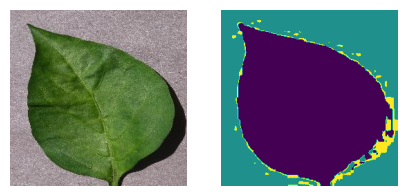

40 Pepper,_bell___healthy 0e69c47d-72c6-4fc6-9437-910c95b183dc___JR_HL 8113.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[340.66406250000006, 460.1111111111111, 326.4973958333334, 340.66406250000006, 0.9609662383389971, 0.9472678895300931, 0.9625849006028919, 0.9609662383389971, 0.6116925917709175, 0.6076982359914721, 0.6120720468672104, 0.6116925917709175, 0.9741756306119709, 0.9624341305733567, 0.9744820179985331, 0.9741756306119709, 0.3741678268274223, 0.3692971460271469, 0.37463219055621655, 0.3741678268274223, 2.7994791666666674, 3.9333333333333336, 2.7265625, 2.7994791666666674, '

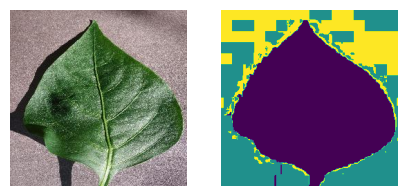

41 Pepper,_bell___healthy 0eabc3c2-d492-4227-90d8-14dab9fd4a9a___JR_HL 8699.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[279.68098958333337, 364.1111111111111, 314.32291666666663, 279.68098958333337, 0.9413539150603183, 0.9236843847539884, 0.934032220629122, 0.9413539150603183, 0.6714021510958588, 0.6686342726739696, 0.6712495004153639, 0.6714021510958588, 0.9796284106318871, 0.9719831112298374, 0.978326386660826, 0.9796284106318871, 0.4507808484961464, 0.44707179059424834, 0.4505758918078756, 0.4507808484961464, 2.251302083333334, 3.015686274509804, 2.460937499999999, 2.25130208333333

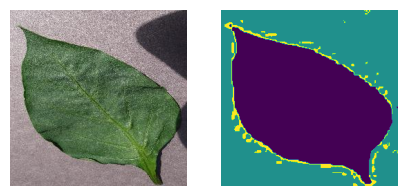

42 Pepper,_bell___healthy 0eb476b9-8b21-4b24-adef-7db813abbca3___JR_HL 7926.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[301.15234374999994, 409.7777777777778, 318.41796875, 301.15234374999994, 0.9469407415433738, 0.9273678425951914, 0.9435687505987324, 0.9469407415433738, 0.6989661006245985, 0.697348613340059, 0.6992367686620479, 0.6989661006245985, 0.9804706865842495, 0.9727209424903568, 0.9800570725157965, 0.9804706865842495, 0.4885536098223564, 0.48629508852730324, 0.48893205864894224, 0.4885536098223564, 2.287760416666667, 3.152941176470588, 2.3789062500000004, 2.287760416666667, 

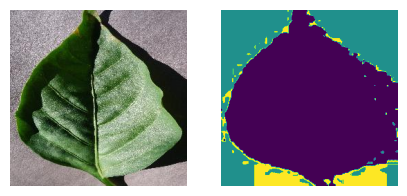

43 Pepper,_bell___healthy 1b574484-60cd-4ae4-83ed-511a5ae07ea8___JR_HL 7849.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[600.0911458333334, 744.3333333333331, 643.3658854166666, 600.0911458333334, 0.8815385972942075, 0.8524550503083799, 0.8733179938227107, 0.8815385972942075, 0.6744435299983539, 0.672934140866356, 0.6741403717815045, 0.6744435299983539, 0.9731941658114092, 0.9664612921430219, 0.9725353715603977, 0.9731941658114092, 0.4548740751566404, 0.45284035794354066, 0.45446524086570517, 0.4548740751566404, 3.8723958333333335, 4.819607843137254, 4.079427083333334, 3.87239583333333

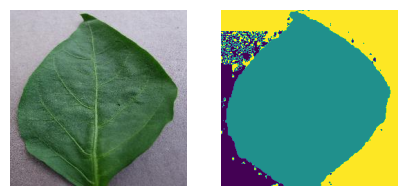

44 Pepper,_bell___healthy 1bfa8779-be94-4f16-9668-08c91f9ce3d6___JR_HL 8358.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[259.98046875, 323.4444444444445, 206.5234375, 259.98046875, 0.9412349856770262, 0.9268261643489392, 0.9532370680566147, 0.9412349856770262, 0.6804385742626071, 0.6789564531572149, 0.6824821161613986, 0.6804385742626071, 0.9809303630577241, 0.9763193492972151, 0.9854335164316659, 0.9809303630577241, 0.46299665334452944, 0.46098186528382534, 0.4657818388801408, 0.46299665334452944, 2.100260416666667, 2.6104575163398698, 1.6354166666666665, 2.100260416666667, 'Pepper,_b

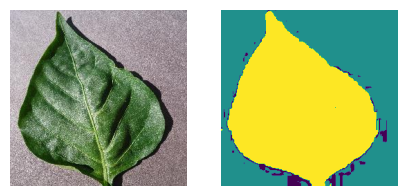

45 Pepper,_bell___healthy 1bfbdcd9-68ae-4676-9693-5f02fd310860___JR_HL 8715.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[513.9843750000001, 731.8888888888891, 445.4752604166667, 513.9843750000001, 0.8972846585761952, 0.8536625860430854, 0.9110853530526155, 0.8972846585761952, 0.6631422714949717, 0.6590681744962082, 0.6643347749241523, 0.6631422714949717, 0.9756910824652718, 0.9656002934799792, 0.9791068735080306, 0.9756910824652718, 0.43975767224351076, 0.43437085863376435, 0.4413406931735241, 0.43975767224351076, 3.3932291666666674, 4.8196078431372555, 2.9309895833333335, 3.3932291666

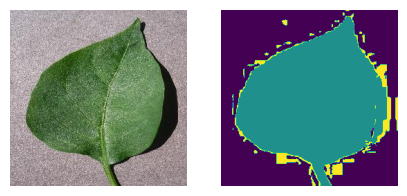

46 Pepper,_bell___healthy 1c043016-2d55-444d-a379-4a2aafc41a32___JR_HL 7909.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[374.0885416666667, 440.0, 235.96354166666666, 374.0885416666667, 0.939631789637624, 0.9288639488847977, 0.9617879789369201, 0.939631789637624, 0.6647693881486151, 0.6632691701624914, 0.6688385489873809, 0.6647693881486151, 0.973501567550256, 0.9670624149768157, 0.9829215551421349, 0.973501567550256, 0.44191833941948405, 0.43992599208803995, 0.44734500461154514, 0.44191833941948405, 2.9687499999999996, 3.5921568627450977, 1.8932291666666667, 2.9687499999999996, 'Peppe

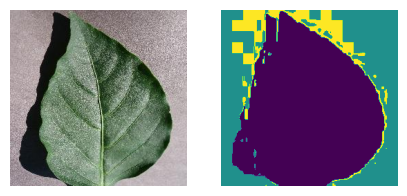

47 Pepper,_bell___healthy 1c159479-4972-41d3-a6ff-fbdb648d72c2___JR_HL 7575.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[374.53124999999994, 506.77777777777777, 308.8997395833333, 374.53124999999994, 0.9089671634926065, 0.8765896917235588, 0.9249274696190285, 0.9089671634926065, 0.692217000679476, 0.6891666292385261, 0.6933138253990254, 0.692217000679476, 0.9796432724297611, 0.9713827625184838, 0.9825689384116955, 0.9796432724297611, 0.47916437602968964, 0.4749506428559921, 0.48068406048943024, 0.47916437602968964, 2.6223958333333335, 3.6091503267973857, 2.1992187499999996, 2.622395833

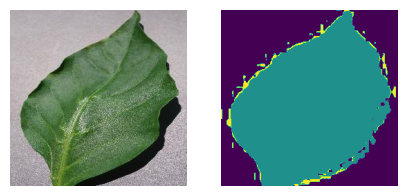

48 Pepper,_bell___healthy 1c41486f-bb0d-4808-b980-9fa4739f2ad3___JR_HL 8459.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[309.2317708333333, 391.55555555555543, 255.8854166666666, 309.2317708333333, 0.9337669914456925, 0.9161245988006628, 0.9452430217644383, 0.9337669914456925, 0.6847271318892999, 0.6826879601933062, 0.6855646669599825, 0.6847271318892999, 0.9798120608619875, 0.9733975755147047, 0.9827836159505118, 0.9798120608619875, 0.4688512451453467, 0.46606285099289724, 0.4699989125839518, 0.4688512451453467, 2.3567708333333335, 3.04313725490196, 1.9791666666666665, 2.3567708333333

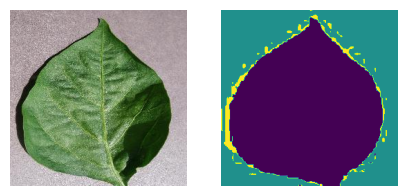

49 Pepper,_bell___healthy 1c665f14-938a-4563-8613-031a2cb04453___JR_HL 5815.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[337.4544270833333, 500.22222222222223, 357.9296875, 337.4544270833333, 0.9633517079511787, 0.9456913609737476, 0.9611691032475216, 0.9633517079511787, 0.6114680724197208, 0.6068974100610761, 0.6105843674737081, 0.6114680724197208, 0.976963153895868, 0.9645404560148538, 0.9751404545234248, 0.976963153895868, 0.3738932035886889, 0.36832446633884197, 0.3728132698032683, 0.3738932035886889, 2.62890625, 3.9712418300653596, 2.8125, 2.62890625, 'Pepper,_bell___healthy']


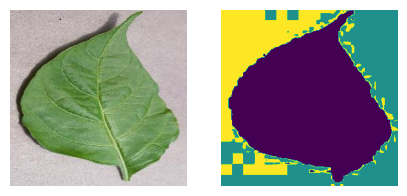

50 Pepper,_bell___healthy 1dab0ba9-9982-46ec-9ef6-70a1698baf04___JR_HL 8690.JPG -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[240.61197916666663, 299.0, 236.29557291666669, 240.61197916666663, 0.9668006017454563, 0.9587222456570924, 0.9673999761457153, 0.9668006017454563, 0.6402564395074387, 0.6381122942452339, 0.6404872881551352, 0.6402564395074387, 0.980440344519788, 0.9737055395106842, 0.9806241569190626, 0.980440344519788, 0.40992830833074256, 0.40718730006691595, 0.41022396628831925, 0.40992830833074256, 2.052083333333333, 2.6627450980392156, 2.0247395833333335, 2.052083333333333, 'Pep

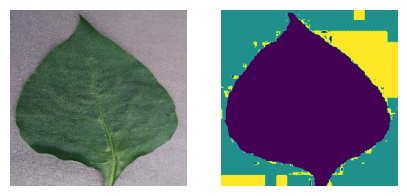

Done!!
Execution time: 11.5974 seconds


In [7]:
data_dir = "D:/pythonProject/datasets/test-dataset/color/train-50"
csv_file_path = "D:/pythonProject/Image-research/vision/color-train-50.csv"
processImages(data_dir, csv_file_path, printImages=True, num_clusters=3)

In [10]:
data_dir = "D:/pythonProject/datasets/test-dataset/segmented/train-40"
csv_file_path = "D:/pythonProject/Image-research/vision/segmented-train-40.csv"
processImages(data_dir, csv_file_path, printImages=False)

==================Image Processing==================
CSV file 'D:/pythonProject/Image-research/vision/segmented-train-40.csv' not found.
1 Pepper,_bell___Bacterial_spot 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132_final_masked.jpg -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[308.125, 412.55555555555554, 269.27734375, 308.125, 0.933363574143275, 0.9107804083099893, 0.9417483337358321, 0.933363574143275, 0.67208880062775, 0.6675017350659574, 0.6735472562590353, 0.67208880062775, 0.9711891707984374, 0.9616348041967208, 0.9744516600351328, 0.9711891707984374, 0.45170335592924743, 0.44

In [12]:
data_dir = "D:/pythonProject/datasets/test-dataset/segmented/train-40b"
csv_file_path = os.path.join("D:/pythonProject/Image-research/vision/segmented-train-40b.csv")
processImages(data_dir, csv_file_path, printImages=False)

==================Image Processing==================
CSV file 'D:/pythonProject/Image-research/vision/segmented-train-40b.csv' deleted successfully.
1 Pepper,_bell___Bacterial_spot 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132_final_masked.jpg -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[308.125, 412.55555555555554, 269.27734375, 308.125, 0.933363574143275, 0.9107804083099893, 0.9417483337358321, 0.933363574143275, 0.67208880062775, 0.6675017350659574, 0.6735472562590353, 0.67208880062775, 0.9711891707984374, 0.9616348041967208, 0.9744516600351328, 0.9711891707984374, 0.45170335592

In [19]:
data_dir = "D:/pythonProject/datasets/test-dataset/segmented/train-50"
csv_file_path = "D:/pythonProject/Image-research/vision/segmented-train-50.csv"
processImages(data_dir, csv_file_path, printImages=False)

==================Image Processing==================
CSV file 'D:/pythonProject/Image-research/vision/segmented-train-50.csv' deleted successfully.
1 Pepper,_bell___Bacterial_spot 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132_final_masked.jpg -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[308.125, 412.55555555555554, 269.27734375, 308.125, 0.933363574143275, 0.9107804083099893, 0.9417483337358321, 0.933363574143275, 0.67208880062775, 0.6675017350659574, 0.6735472562590353, 0.67208880062775, 0.9711891707984374, 0.9616348041967208, 0.9744516600351328, 0.9711891707984374, 0.451703355929

In [20]:
data_dir = "D:/pythonProject/datasets/test-dataset/segmented/train-mixed"
csv_file_path = "D:/pythonProject/Image-research/vision/segmented-train-mixed.csv"
processImages(data_dir, csv_file_path, printImages=True)

==================Image Processing==================
CSV file 'D:/pythonProject/Image-research/vision/segmented-train-mixed.csv' deleted successfully.
1 Pepper,_bell___Bacterial_spot 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132_final_masked.jpg -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[308.125, 412.55555555555554, 269.27734375, 308.125, 0.933363574143275, 0.9107804083099893, 0.9417483337358321, 0.933363574143275, 0.67208880062775, 0.6675017350659574, 0.6735472562590353, 0.67208880062775, 0.9711891707984374, 0.9616348041967208, 0.9744516600351328, 0.9711891707984374, 0.451703355

In [16]:
data_dir = "D:/pythonProject/datasets/test-dataset/segmented/trainb-50"
csv_file_path = "D:/pythonProject/Image-research/vision/segmented-trainb-50.csv"
processImages(data_dir, csv_file_path, printImages=False)

==================Image Processing==================
CSV file 'D:/pythonProject/Image-research/vision/segmented-trainb-50.csv' deleted successfully.
1 Tomato___Early_blight 004cbe60-8ff9-4965-92df-e86694d5e9ba___RS_Erly.B 8253_final_masked.jpg -------------------------------------------------------------
['contrast_0', 'contrast_45', 'contrast_90', 'contrast_135', 'correlation_0', 'correlation_45', 'correlation_90', 'correlation_135', 'energy_0', 'energy_45', 'energy_90', 'energy_135', 'homogeneity_0', 'homogeneity_45', 'homogeneity_90', 'homogeneity_135', 'ASM_0', 'ASM_45', 'ASM_90', 'ASM_135', 'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90', 'dissimilarity_135', 'label']
[333.5807291666667, 483.33333333333314, 368.0013020833334, 333.5807291666667, 0.9277905733023949, 0.8950967295242874, 0.9204514714843329, 0.9277905733023949, 0.7090787747114814, 0.7043129558495828, 0.70925970777081, 0.7090787747114814, 0.9666095716177725, 0.9536850524959878, 0.9655679203250676, 0.9666095716